# ABC Analysis

ABC Analysis is used by Inventory management to prioritize efforts and achieve higher financial results:  
In that analysis all variety of products are grouped into 3 main categories:
- A - items that have a highest value to the business, due to higher usage rate and/or higher cost (therefore such items need highest control)
- B - important but are less essential to lower value or lower sales volume or both
- C - have least impact on sales, with the lowest profit margins


- Мы будем использовать Google Sheets API чтобы читать данные с помощью Python
    - Create Service account: *Service_account_name@valiant-azimuth-365009.iam.gserviceaccount.com* and share google sheet with this account
    - use keys.json file from google api service

In [303]:
# imports:

# work with data:
import pandas as pd
import numpy as np
from abc_analysis import abc_analysis

# visualization:
from matplotlib import pyplot as plt
import seaborn as sns

#google services:
from google.oauth2 import service_account
from googleapiclient.discovery import build


In [304]:
# get data

SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SERVICE_ACCOUNT_FILE = 'keys.json'

creds = None
creds = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes = SCOPES
)

SAMPLE_SPREADSHEET_ID = '1nVrbIaakrv7TpZEpA5ivz1LFAILIWLMJ7Z3eBappCQ0'
SAMPLE_RANGE_NAME = 'segment_values!A18:E2672'

service = build('sheets', 'v4', credentials=creds)

# call API:
sheet = service.spreadsheets()
result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                            range=SAMPLE_RANGE_NAME).execute()

# first row will be names of columns
columns_list = result['values'][0]
# data all other lists:
data = result['values'][1:]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = columns_list)
df.head(3)

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал
0,А00527,Арка межкомнатная шпонированная Владимирская ф...,4430,5890,None
1,А00528,Арка межкомнатная шпонированная Владимирская ф...,4430,5890,None
2,А00529,Арка межкомнатная шпонированная Владимирская ф...,4430,5890,None


## Подготовка данных

In [305]:
# пустые значения
df.isnull().sum()

Артикул                            0
Название товара                    0
Цена закупки                       0
Цена продажи                       0
Количество продаж за квартал    2112
dtype: int64

Пустые значения присутствуют только в колонке количество продаж. Пустое значение в этой колонке означает отсутствие продаж по товару в исследуемом квартале  
Заменим пустые значения на 0:

In [306]:
# fillna with 0:
df = df.fillna(0)

In [307]:
# типы данных:
df.dtypes

Артикул                         object
Название товара                 object
Цена закупки                    object
Цена продажи                    object
Количество продаж за квартал    object
dtype: object

Все данные считались как текстовые.  
Заменим тип данных для численных значений:

In [308]:
df['Цена закупки'] = df['Цена закупки'].astype(float)
df['Цена продажи'] = df['Цена продажи'].astype(float)
df['Количество продаж за квартал'] = df['Количество продаж за квартал'].astype(int)

# Analysis

### 1 Подготовить список наиболее ценного ассортимента который приносит наибольшую прибыль. 

$$ Прибыль =  Выручка – Затраты $$

In [309]:
# Расчитаем прибыль для одной единицы каждого товара:
df['Маржа'] = df['Цена продажи'] - df['Цена закупки']
df['Прибыль'] = df['Маржа'] * df['Количество продаж за квартал']

Проверим данные на валидность:
- присутствуют ли товары с отрицательной прибылью?


In [310]:
number_of_items_negative_profit = len(df[df['Прибыль'] < 0])
print(f'В выборке присутствует {number_of_items_negative_profit} с отицательной прибылью ща квартал')

В выборке присутствует 6 с отицательной прибылью ща квартал


In [311]:
df[df['Прибыль'] < 0]

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал,Маржа,Прибыль
386,ДМ00194,"Дверь межкомнатная Верда ДПГ, цвет белый, лами...",1050.0,950.0,9,-100.0,-900.0
475,ДМ01097,"Дверь межкомнатная Сибирь Профиль ДПГ, цвет ит...",836.0,750.0,8,-86.0,-688.0
476,ДМ01101,"Дверь межкомнатная Сибирь Профиль ДПГ, цвет ми...",836.0,750.0,7,-86.0,-602.0
750,ДМ13555,Дверь межкомнатная раздвижная Сибирь Профиль Д...,836.0,750.0,1,-86.0,-86.0
1280,ДМ20147,"Дверь межкомнатная Дуплекс Биланчино 06, цвет ...",2589.0,2440.0,9,-149.0,-1341.0
2653,Ф35563,Фурнитура - Защёлка Межкомнатная Морелли L6-45...,104000.0,210.0,2,-103790.0,-207580.0


В целом ситуация с отрицательной прибылью возможна при различных условиях (изменение цен на комплектующие, демпинг цен и др.)  
Однако, подозрение вызывает одна позиция с слишком высокой разницей между ценой закупки и продажи:

In [312]:
df[df['Прибыль'] < -100000]

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал,Маржа,Прибыль
2653,Ф35563,Фурнитура - Защёлка Межкомнатная Морелли L6-45...,104000.0,210.0,2,-103790.0,-207580.0


Учитывая, что это фурнитура-защелка, столь высокая цена закупки вызывает еще большее подозрение.  
В рамках текущего анализа, отфильтруем эту позицию и поставим задачу на проверку наличия ошибки в данных

In [313]:
# filter value with too lowe Profit:
df = df[df['Прибыль'] > -100000]

Отсортируем полученную таблицу в порядке убывания прибыли и покажем ТОП-10 товаров с самой высокой прибылью за квартал:

In [314]:
df_top_10_items = df.sort_values(by='Прибыль', ascending=False).head(10)
df_top_10_items

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал,Маржа,Прибыль
183,ДВ25829,"Дверь входная Гарда 7,5 см муар царга, 2 замка...",10000.0,13941.0,32,3941.0,126112.0
2344,Ф27023,Фурнитура - Ручка Дверная Ручетти RAP17-SSN/CP...,422.0,790.0,313,368.0,115184.0
2372,Ф27053,Фурнитура - Навес врезная Морелли MS100X70X2.5...,88.0,190.0,1020,102.0,104040.0
930,ДМ14448,"Дверь межкомнатная Оптима Порте Турин 506.12, ...",2500.0,3490.0,97,990.0,96030.0
2371,Ф27052,Фурнитура - Замок Сантехнический Морелли 2070P...,221.0,490.0,286,269.0,76934.0
2351,Ф27030,"Фурнитура - Завёртка Ручетти RAPWC-SSN/CP, цве...",240.0,530.0,225,290.0,65250.0
147,ДВ23787,"Дверь входная Цитадель ДМП- 01 EI 60, 1 замок,...",9400.0,13020.0,16,3620.0,57920.0
1555,ДМ32741,"Дверь межкомнатная Оптима Порте Турин 506.12, ...",2500.0,3490.0,58,990.0,57420.0
1609,ДМ32795,"Дверь межкомнатная Оптима Порте Турин 506.12, ...",2500.0,3490.0,55,990.0,54450.0
2368,Ф27049,Фурнитура - Защёлка Межкомнатная Морелли LP6-4...,104.0,230.0,415,126.0,52290.0


Визуализируем результаты:

<AxesSubplot:xlabel='Артикул', ylabel='Прибыль'>

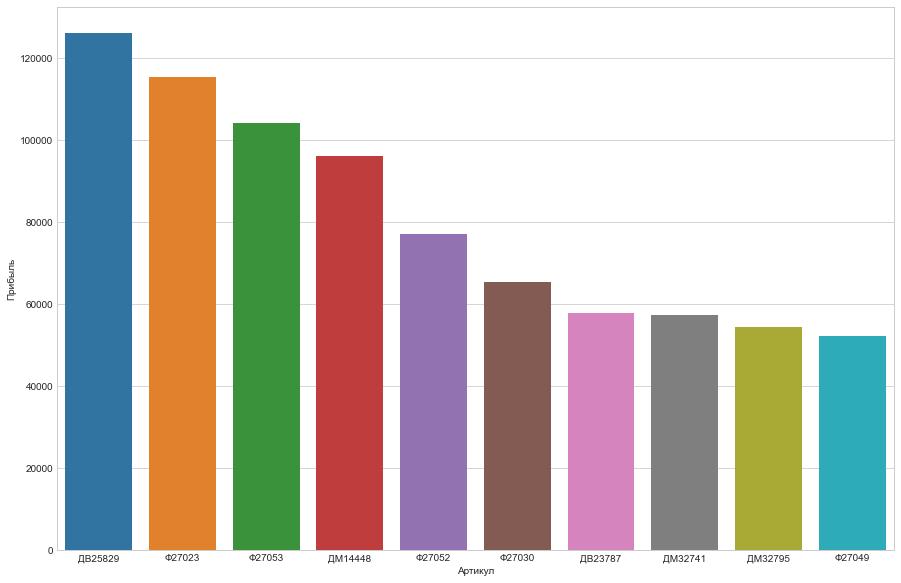

In [315]:
plt.figure(figsize=(15,10))
sns.barplot(data = df_top_10_items, x='Артикул', y='Прибыль')

Посмотрим также на относительные значения (% от общей прибыли за квартал)

<AxesSubplot:xlabel='Артикул', ylabel='Доля от общей прибыли, %'>

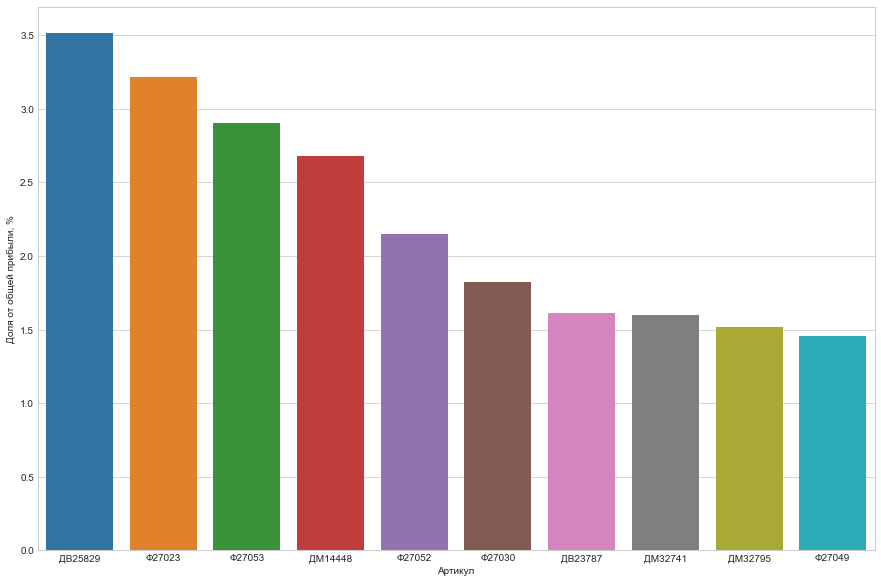

In [316]:
total_profit = df['Прибыль'].sum()

# calc % of total:
df['Доля от общей прибыли, %'] = df['Прибыль'] / total_profit * 100

df_top_10_items = df.sort_values(by='Прибыль', ascending=False).head(10)

# visualize:
plt.figure(figsize=(15,10))
sns.barplot(data = df_top_10_items, x='Артикул', y='Доля от общей прибыли, %')

# 2 Подготовить описание группы наиболее ценных товаров (общие особенности товаров входящих в эту группу).

Присвоим признак тип товара

In [317]:
def item_type(item_name):
    result = item_name.split(' ')[0]
    return result

df['Тип товара'] = df['Название товара'].apply(lambda x: item_type(x))

In [318]:
df['Тип товара'].unique()

array(['Арка', 'Дверь', 'Термодверь', 'Тёплая', 'Сейф-дверь',
       'Перегородка', 'Фурнитура'], dtype=object)

Видно, что термодверь, теплая, сейф-дверь и просто дверь это все типы дверей, тем не менее мы можем посмотреть на структуру продаж по таким категориям

In [319]:
# Считаем сумму прибыли, среднюю маржу и количество товаров:
df_types_profit = df.groupby('Тип товара', as_index=False).agg({
    'Прибыль': sum,
    'Артикул': 'count',
    'Маржа': 'mean'
})
df_types = df_types_profit.sort_values(by='Прибыль', ascending=False)
df_types.columns = ['Тип товара', 'Сумма прибыли', 'Количество товаров', 'Средняя маржа']
df_types


,Тип товара,Сумма прибыли,Количество товаров,Средняя маржа
1,Дверь,1779597.0,1829,1377.328595
6,Фурнитура,1247953.0,571,435.131349
5,Тёплая,277771.0,93,4545.021505
4,Термодверь,234797.0,47,6151.617021
3,Сейф-дверь,29920.0,34,6708.235294
0,Арка,7980.0,51,1543.725490
2,Перегородка,7500.0,28,818.571429


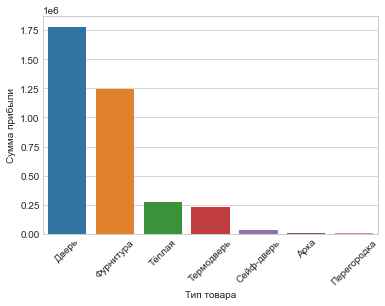

In [320]:
types_plot = sns.barplot(data = df_types, x='Тип товара', y='Сумма прибыли')
for item in types_plot.get_xticklabels():
    item.set_rotation(45)

Мы видим что больше всего компания зарабатывает на обычных дверях и фурнитуре, так как их продается больше всего, однако средняя маржа выше в типе Термодверь и Сейф-дверь

Посмотрим какие типы товаров попали в Топ-10 самых прибыльных:

In [321]:
df_top_10_items = df.sort_values(by='Прибыль', ascending=False).head(10)
df_top_10_items[[
    'Название товара',
    'Количество продаж за квартал',
    'Маржа',
    'Прибыль',
    'Тип товара'
]]

,Название товара,Количество продаж за квартал,Маржа,Прибыль,Тип товара
183,"Дверь входная Гарда 7,5 см муар царга, 2 замка...",32,3941.0,126112.0,Дверь
2344,Фурнитура - Ручка Дверная Ручетти RAP17-SSN/CP...,313,368.0,115184.0,Фурнитура
2372,Фурнитура - Навес врезная Морелли MS100X70X2.5...,1020,102.0,104040.0,Фурнитура
930,"Дверь межкомнатная Оптима Порте Турин 506.12, ...",97,990.0,96030.0,Дверь
2371,Фурнитура - Замок Сантехнический Морелли 2070P...,286,269.0,76934.0,Фурнитура
2351,"Фурнитура - Завёртка Ручетти RAPWC-SSN/CP, цве...",225,290.0,65250.0,Фурнитура
147,"Дверь входная Цитадель ДМП- 01 EI 60, 1 замок,...",16,3620.0,57920.0,Дверь
1555,"Дверь межкомнатная Оптима Порте Турин 506.12, ...",58,990.0,57420.0,Дверь
1609,"Дверь межкомнатная Оптима Порте Турин 506.12, ...",55,990.0,54450.0,Дверь
2368,Фурнитура - Защёлка Межкомнатная Морелли LP6-4...,415,126.0,52290.0,Фурнитура


Так как типы Дверь и Фурнитура, как мы увидели составляют наибольшую долю в прибыли компании, следовательно необходимо выделить больше под-типов в этих типах:

In [322]:
def sub_type(item_name):
    type = item_name.split(' ')[0]
    if type == 'Дверь':
        subtype = item_name.split(' ')[1]
    elif type == 'Фурнитура':
        subtype = item_name.split(' ')[2]
    else:
        subtype = type # мы разбиваем категории только для Типов Дверь и Фурнитура
    return subtype

df['Подтип'] = df['Название товара'].apply(lambda x: sub_type(x))
df.head(3)

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал,Маржа,Прибыль,"Доля от общей прибыли, %",Тип товара,Подтип
0,А00527,Арка межкомнатная шпонированная Владимирская ф...,4430.0,5890.0,0,1460.0,0.0,0.0,Арка,Арка
1,А00528,Арка межкомнатная шпонированная Владимирская ф...,4430.0,5890.0,0,1460.0,0.0,0.0,Арка,Арка
2,А00529,Арка межкомнатная шпонированная Владимирская ф...,4430.0,5890.0,0,1460.0,0.0,0.0,Арка,Арка


In [323]:
# Считаем сумму прибыли, среднюю маржу и количество товаров:
df_sub_types = df.groupby('Подтип', as_index=False).agg({
    'Прибыль': sum,
    'Артикул': 'count',
    'Маржа': 'mean'
})
df_sub_types = df_sub_types.sort_values(by='Прибыль', ascending=False)
df_sub_types.columns = ['Подтип', 'Сумма прибыли', 'Количество товаров', 'Средняя маржа']
df_sub_types.reset_index(drop=True).round()

,Подтип,Сумма прибыли,Количество товаров,Средняя маржа
0,межкомнатная,1258345.0,1686,1190.0
1,входная,521252.0,143,3582.0
2,Ручка,450753.0,293,413.0
3,Тёплая,277771.0,93,4545.0
4,Термодверь,234797.0,47,6152.0
5,Навес,204808.0,20,115.0
6,Замок,188756.0,36,400.0
7,Завёртка,147923.0,49,345.0
8,Защёлка,68309.0,12,184.0
9,Комплект,55797.0,19,2475.0


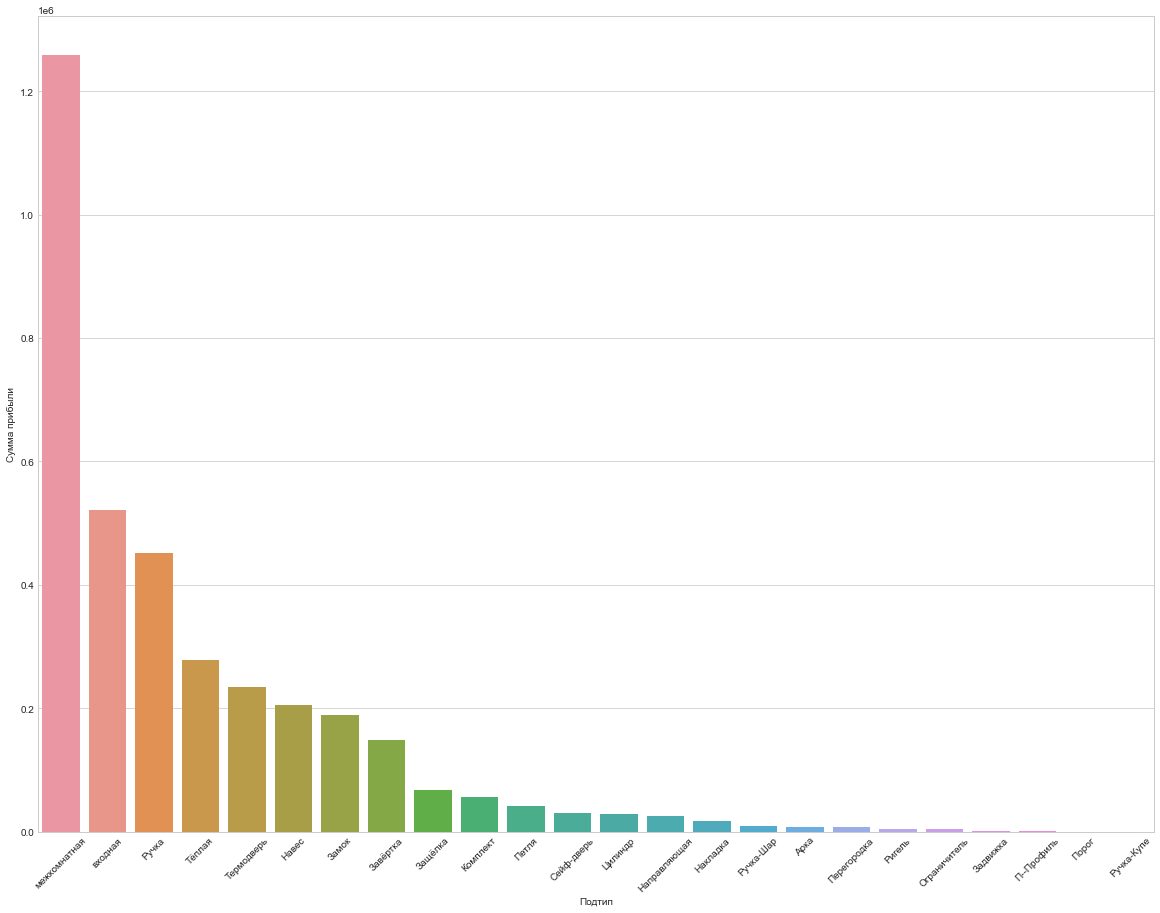

In [324]:
plt.figure(figsize=(20,15))

sub_types_plot = sns.barplot(data = df_sub_types, x='Подтип', y='Сумма прибыли')
for item in sub_types_plot.get_xticklabels():
    item.set_rotation(45)

Мы можем увидеть, что лидерами продаж являются межкомнатные двери, а также входные двери, далее следует дверная ручка

# Принцип Парето  
В дальнейшем анализе мы будет пользоваться так называемым правилом Парето:  
*Небольшая группа товаров приносит основную часть прибыли*  

В среднем это правило может быть сформулировано:
- Category A: 20% товаров, которые приносят 80% прибыли
- Category B: 30% товаров, которые приносят 15% прибыли 
- Category C: 50% товаров, которые приносят 5% прибыли

Выделим те, товары, которые приносят компании 80% всей прибыли:

In [325]:
df = df.sort_values(by='Прибыль', ascending=False)
df['cumulative_profit_share, %'] = df['Доля от общей прибыли, %'].cumsum(axis=0)
df_top = df[df['cumulative_profit_share, %'] <= 80]
df_top

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал,Маржа,Прибыль,"Доля от общей прибыли, %",Тип товара,Подтип,"cumulative_profit_share, %"
183,ДВ25829,"Дверь входная Гарда 7,5 см муар царга, 2 замка...",10000.0,13941.0,32,3941.0,126112.0,3.517260,Дверь,входная,3.517260
2344,Ф27023,Фурнитура - Ручка Дверная Ручетти RAP17-SSN/CP...,422.0,790.0,313,368.0,115184.0,3.212479,Фурнитура,Ручка,6.729739
2372,Ф27053,Фурнитура - Навес врезная Морелли MS100X70X2.5...,88.0,190.0,1020,102.0,104040.0,2.901673,Фурнитура,Навес,9.631412
930,ДМ14448,"Дверь межкомнатная Оптима Порте Турин 506.12, ...",2500.0,3490.0,97,990.0,96030.0,2.678274,Дверь,межкомнатная,12.309686
2371,Ф27052,Фурнитура - Замок Сантехнический Морелли 2070P...,221.0,490.0,286,269.0,76934.0,2.145687,Фурнитура,Замок,14.455373
...,...,...,...,...,...,...,...,...,...,...,...
237,ДВ29911,"Термодверь входная Изотерма 11 см, 2 замка, 1,...",18700.0,24171.0,1,5471.0,5471.0,0.152586,Термодверь,Термодверь,79.301484
1024,ДМ16596,"Дверь межкомнатная Оптима Порте Турин 502.11, ...",2800.0,3890.0,5,1090.0,5450.0,0.152000,Дверь,межкомнатная,79.453485
1933,ДМ35109,Дверь межкомнатная Оптима Порте Парма 422.2222...,3440.0,4790.0,4,1350.0,5400.0,0.150606,Дверь,межкомнатная,79.604091
2114,Ф00620,"Фурнитура - Ручка Дверная Ренц Рим, цвет никел...",893.0,1430.0,10,537.0,5370.0,0.149769,Фурнитура,Ручка,79.753860


Мы получили 167 товаров, которые составяют 80% всей прибыли компании за квартал

Посмотрим как представлены типы и подтипы товаров в этой выборке:

In [326]:
# Считаем сумму прибыли, среднюю маржу и количество товаров:
df_sub_types_top = df_top.groupby('Подтип', as_index=False).agg({
    'Прибыль': sum,
    'Артикул': 'count',
    'Маржа': 'mean'
})
df_sub_types_top = df_sub_types_top.sort_values(by='Прибыль', ascending=False)
df_sub_types_top.columns = ['Подтип', 'Сумма прибыли', 'Количество товаров', 'Средняя маржа']
df_sub_types_top.reset_index(drop=True).round()

,Подтип,Сумма прибыли,Количество товаров,Средняя маржа
0,межкомнатная,950310.0,66,1223.0
1,входная,450732.0,22,2920.0
2,Ручка,341708.0,21,336.0
3,Термодверь,220327.0,14,5567.0
4,Тёплая,211854.0,17,4759.0
5,Навес,196278.0,7,104.0
6,Замок,166400.0,6,407.0
7,Завёртка,121626.0,4,311.0
8,Защёлка,64450.0,2,253.0
9,Комплект,47160.0,2,1720.0


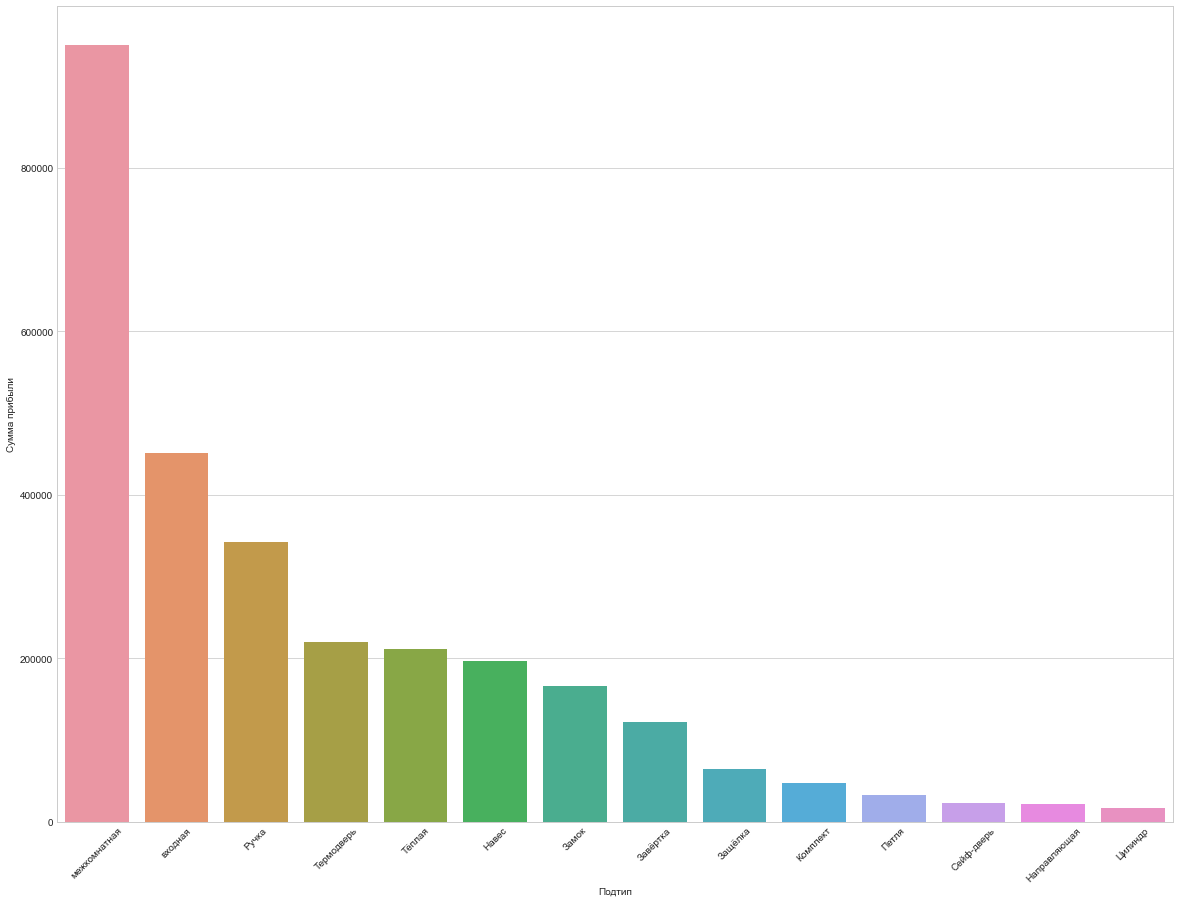

In [327]:
plt.figure(figsize=(20,15))

sub_types_plot = sns.barplot(data = df_sub_types_top, x='Подтип', y='Сумма прибыли')
for item in sub_types_plot.get_xticklabels():
    item.set_rotation(45)

Мы видим, что в товарах, вошедших в топ 80% по продажам, попали только 13 из 23 подтипов товаров

## 3 Подготовить список наименее ценного ассортимента который приносит наименьшую прибыль.

Вновь воспользуемся правилом Паретто и выберем товары, которые приносят только 5% всей прибыли

In [328]:
df = df.sort_values(by='Прибыль', ascending=True) # теперь отстортируем данные по возрастанию прибыли:
df['cumulative_profit_share, %'] = df['Доля от общей прибыли, %'].cumsum(axis=0)
df_bottom = df[df['cumulative_profit_share, %'] <= 5]
df_bottom

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал,Маржа,Прибыль,"Доля от общей прибыли, %",Тип товара,Подтип,"cumulative_profit_share, %"
1280,ДМ20147,"Дверь межкомнатная Дуплекс Биланчино 06, цвет ...",2589.0,2440.0,9,-149.0,-1341.0,-0.037400,Дверь,межкомнатная,-0.037400
386,ДМ00194,"Дверь межкомнатная Верда ДПГ, цвет белый, лами...",1050.0,950.0,9,-100.0,-900.0,-0.025101,Дверь,межкомнатная,-0.062501
475,ДМ01097,"Дверь межкомнатная Сибирь Профиль ДПГ, цвет ит...",836.0,750.0,8,-86.0,-688.0,-0.019188,Дверь,межкомнатная,-0.081690
476,ДМ01101,"Дверь межкомнатная Сибирь Профиль ДПГ, цвет ми...",836.0,750.0,7,-86.0,-602.0,-0.016790,Дверь,межкомнатная,-0.098479
750,ДМ13555,Дверь межкомнатная раздвижная Сибирь Профиль Д...,836.0,750.0,1,-86.0,-86.0,-0.002399,Дверь,межкомнатная,-0.100878
...,...,...,...,...,...,...,...,...,...,...,...
1562,ДМ32748,"Дверь межкомнатная Оптима Порте Турин 501.2, ц...",3000.0,3890.0,2,890.0,1780.0,0.049644,Дверь,межкомнатная,4.753679
2289,Ф13740,"Фурнитура - Ручка Дверная Пуэрто AL 522-02, цв...",452.0,810.0,5,358.0,1790.0,0.049923,Фурнитура,Ручка,4.803602
2480,Ф30084,"Фурнитура - Ручка Дверная Ренц Фиоре, цвет бел...",993.0,1590.0,3,597.0,1791.0,0.049951,Фурнитура,Ручка,4.853553
1766,ДМ33398,"Дверь межкомнатная Порте Лайн Берлин 13, цвет ...",1800.0,2250.0,4,450.0,1800.0,0.050202,Дверь,межкомнатная,4.903754


Мы видим, что в Антирейтинг, то есть наименее прибыльные товары попали 2326 товаров

In [329]:
# Считаем сумму прибыли, среднюю маржу и количество товаров:
df_sub_types_bottom = df_bottom.groupby('Подтип', as_index=False).agg({
    'Прибыль': sum,
    'Артикул': 'count',
    'Маржа': 'mean'
})
df_sub_types_bottom = df_sub_types_bottom.sort_values(by='Прибыль', ascending=True)
df_sub_types_bottom.columns = ['Подтип', 'Сумма прибыли', 'Количество товаров', 'Средняя маржа']
df_sub_types_bottom.reset_index(drop=True).round()

,Подтип,Сумма прибыли,Количество товаров,Средняя маржа
0,Термодверь,0.0,30,6557.0
1,Ручка-Купе,0.0,4,654.0
2,Тёплая,0.0,60,4598.0
3,Порог,0.0,11,1151.0
4,Сейф-дверь,0.0,30,7107.0
5,П--Профиль,510.0,1,170.0
6,входная,1000.0,103,3785.0
7,Направляющая,1046.0,8,587.0
8,Ограничитель,1112.0,18,130.0
9,Цилиндр,1202.0,9,436.0


- Можно увидеть, что в выборке присутствуют подтипы товаров в которых не было продаж за квартал
- Также стоит отметить что в Антирейтинг попали товары из всех подтипов, другими словами нет такого подтипа товаров, который бы гарантировал высокую прибыльность и необходимо рассматривать товары более детально (Это будет также сделано далее в ABC анализе)

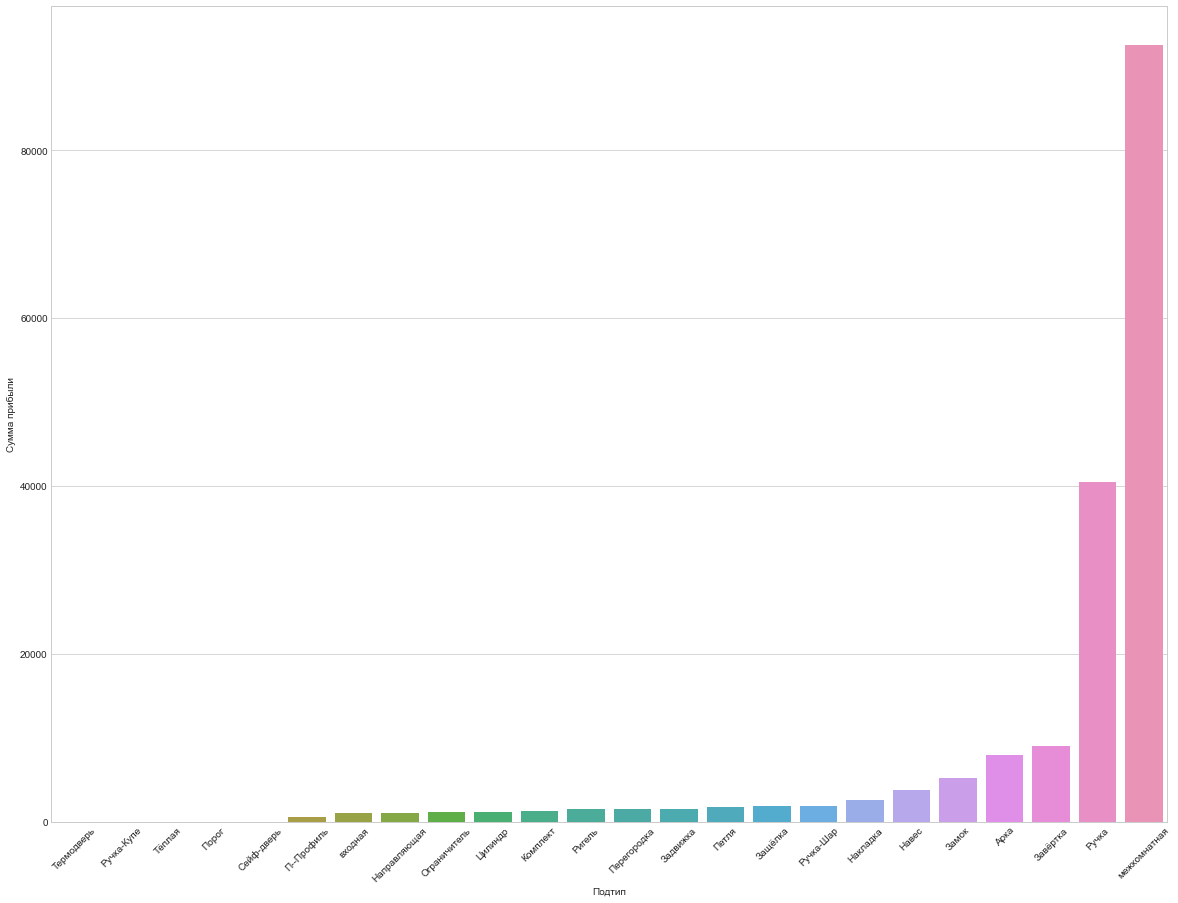

In [330]:
plt.figure(figsize=(20,15))

sub_types_plot = sns.barplot(data = df_sub_types_bottom, x='Подтип', y='Сумма прибыли')
for item in sub_types_plot.get_xticklabels():
    item.set_rotation(45)

### 5 Подготовить список промежуточного ассортимента не относящегося к двум предыдущим группам

Определим те товары, которые ни попали ни в Топ ни в "Антирейтинг":

In [331]:
# filter by inner join:
join_top = pd.merge(df, df_top[['Артикул']], on='Артикул', how='outer', indicator=True)
df_medium = join_top[join_top['_merge'] != 'both']
df_medium = df_medium.drop(columns=['_merge'])
df_medium = pd.merge(df_medium, df_bottom[['Артикул']], on='Артикул', how='outer', indicator=True)
df_medium = df_medium[df_medium['_merge'] != 'both']
df_medium = df_medium.drop(columns=['_merge'])
df_medium

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал,Маржа,Прибыль,"Доля от общей прибыли, %",Тип товара,Подтип,"cumulative_profit_share, %"
2326,ДМ14295,"Дверь межкомнатная Ла Стелла 221, цвет дуб сан...",2977.0,3900.0,2,923.0,1846.0,0.051485,Дверь,межкомнатная,5.005441
2327,ДМ35071,Дверь межкомнатная Оптима Порте Сицилия 721.21...,4730.0,6590.0,1,1860.0,1860.0,0.051875,Дверь,межкомнатная,5.057317
2328,ДМ01135,Дверь межкомнатная Сибирь Профиль Волна (С-10)...,1375.0,2000.0,3,625.0,1875.0,0.052294,Дверь,межкомнатная,5.109610
2329,Ф27051,Фурнитура - Замок Сантехнический Морелли 2070A...,221.0,490.0,7,269.0,1883.0,0.052517,Фурнитура,Замок,5.162127
2330,ДМ17976,"Дверь межкомнатная Румакс Престиж ДГ, цвет каш...",6192.0,8110.0,1,1918.0,1918.0,0.053493,Дверь,межкомнатная,5.215620
...,...,...,...,...,...,...,...,...,...,...,...
2481,ДВ35364,"Тёплая дверь входная Центурион LUX-1, 2 замка,...",20760.0,25890.0,1,5130.0,5130.0,0.143076,Тёплая,Тёплая,19.512132
2482,Ф27927,"Фурнитура - Завёртка Морелли MH-WC-SBL, цвет ч...",332.0,730.0,13,398.0,5174.0,0.144303,Фурнитура,Завёртка,19.656435
2483,ДМ32773,Дверь межкомнатная Оптима Порте Турин 527.121А...,2950.0,3990.0,5,1040.0,5200.0,0.145028,Дверь,межкомнатная,19.801462
2484,Ф27038,Фурнитура - Ручка Дверная Морелли DIY DIYMH-28...,534.0,910.0,14,376.0,5264.0,0.146813,Фурнитура,Ручка,19.948275


Мы получили 160 товаров, которые не вошли ни в Топ ни в "Антирейтинг"

In [332]:
# check total number of records:
n = len(df)
n_top = len(df_top)
n_bottom = len(df_bottom)
n_medium = len(df_medium)
check_sum = n_top + n_bottom + n_medium

print('Проведем проверку общего количества товаров')
print(f'Total number of records: {n}')
print(f'n_top = {n_top}, n_bottom = {n_bottom}, n_medium = {n_medium}')
print(f'check_sum = {check_sum}')

Проведем проверку общего количества товаров
Total number of records: 2653
n_top = 167, n_bottom = 2326, n_medium = 160
check_sum = 2653


Тестовая сумма сошлась с общим числом, следовательно мы правильно произвели разделение

Посмотрим на типы товаров которые попали в "Среднюю" группу:

In [333]:
# Считаем сумму прибыли, среднюю маржу и количество товаров:
df_sub_types_medium = df_medium.groupby('Подтип', as_index=False).agg({
    'Прибыль': sum,
    'Артикул': 'count',
    'Маржа': 'mean'
})
df_sub_types_medium = df_sub_types_medium.sort_values(by='Прибыль', ascending=False)
df_sub_types_medium.columns = ['Подтип', 'Сумма прибыли', 'Количество товаров', 'Средняя маржа']
df_sub_types_medium.reset_index(drop=True).round()

,Подтип,Сумма прибыли,Количество товаров,Средняя маржа
0,межкомнатная,215518.0,68,1130.0
1,входная,69520.0,18,3232.0
2,Ручка,68587.0,21,403.0
3,Тёплая,65917.0,16,4120.0
4,Завёртка,17245.0,4,302.0
5,Замок,17133.0,6,365.0
6,Накладка,15481.0,5,242.0
7,Термодверь,14470.0,3,4823.0
8,Цилиндр,9761.0,3,484.0
9,Комплект,7422.0,2,2563.0


Не все подтипы товаров представлены в "Средней" группе

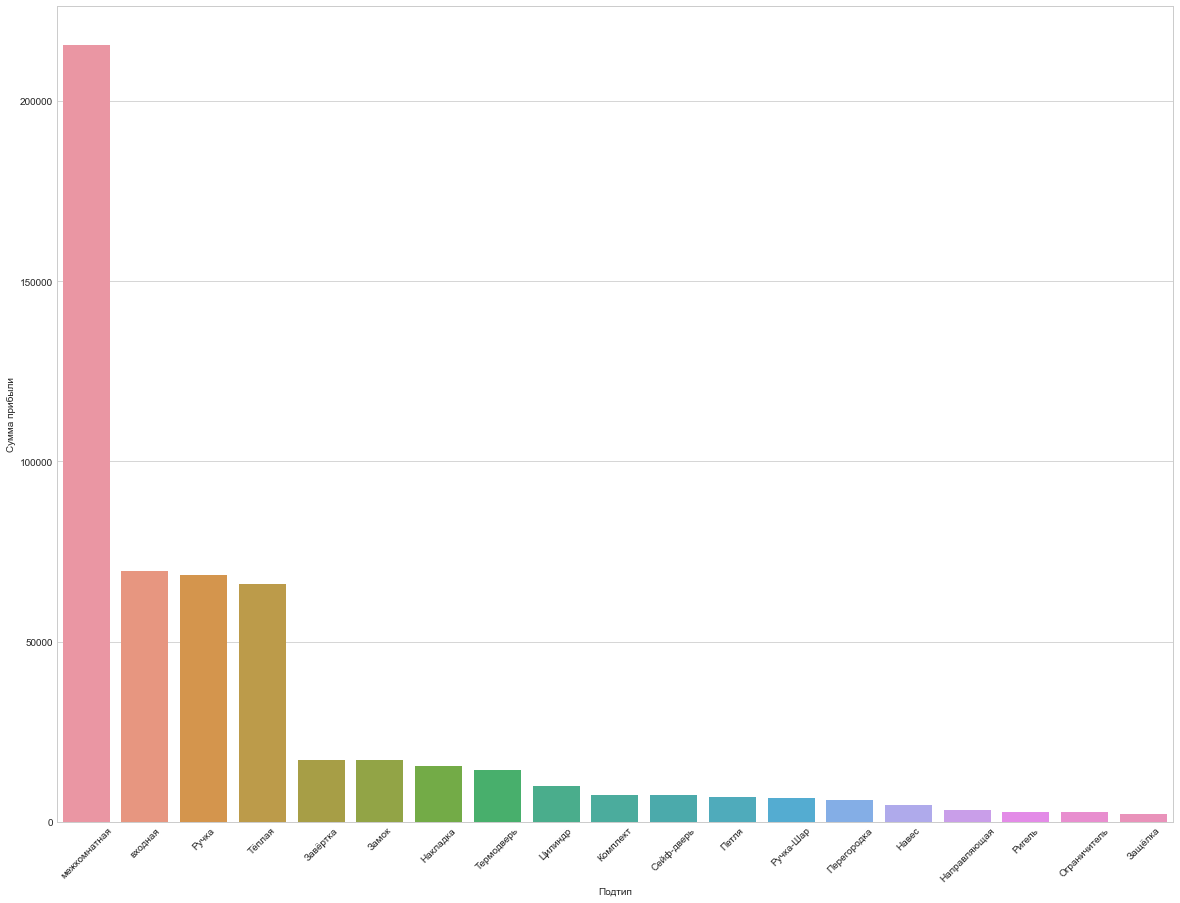

In [334]:
plt.figure(figsize=(20,15))

sub_types_plot = sns.barplot(data = df_sub_types_medium, x='Подтип', y='Сумма прибыли')
for item in sub_types_plot.get_xticklabels():
    item.set_rotation(45)

# ABC Analysis

Полученное выше разделение основано на предложенной нами системе: 80% прибыли - Категория А, однако, возникает вопрос, каким образом можно наиболее эффективно разделить товары на такие 3 группы.  
- Ответом является применение производной для определение прироста прибыли при приращении количества товаров в исследуемой выборке:
    - С добавлением товаров в категорию А мы видим резкий рост суммарной прибыли (при условии сортированных по убыванию данных)
    - Далее скорость роста прибыли замедляется до тех пор пока не переходит в Плато, где прирощение количества товаров, практически не оказывает влияния на прибыль  

Этот алгоритм реализован в функции abc_analysis. Воспользуемся этой функцией, чтобы разделить товары на A,B,C категории и визуализировать резульататы

C:\Users\z004ejty\AppData\Roaming\Python\Python310\site-packages\abc_analysis\abc_analysis.py:136: UserWarning: negative values found. Will continue by replacing them by 0. This can lead to unexpected results!
  warnings.warn('negative values found. Will continue by replacing them'\
C:\Users\z004ejty\AppData\Roaming\Python\Python310\site-packages\abc_analysis\abc_analysis.py:163: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = pd.Series([0]).append(y)
C:\Users\z004ejty\AppData\Roaming\Python\Python310\site-packages\abc_analysis\abc_analysis.py:164: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = pd.Series([0]).append(x)
C:\Users\z004ejty\AppData\Roaming\Python\Python310\site-packages\abc_analysis\abc_analysis.py:136: UserWarning: negative values found. Will continue by replacing them by 0. This can lead t

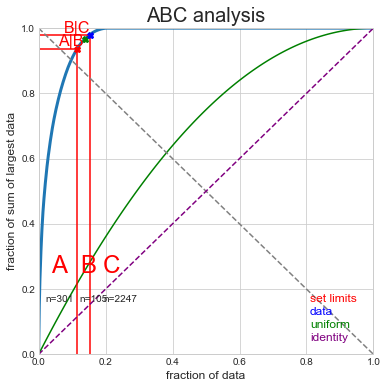

In [335]:
abc = abc_analysis(df['Прибыль'], True)

In [336]:
a_index = abc['Aind']
b_index = abc['Bind']
c_index = abc['Cind']

cond_list = [
    df.index.isin(a_index),
    df.index.isin(b_index),
    df.index.isin(c_index)
]

choice_list = ['A', 'B', 'C']

df['ABC_cat'] = np.select(cond_list, choice_list)
#df = df.sort_values(by='Прибыль', ascending=False)
df.head()

,Артикул,Название товара,Цена закупки,Цена продажи,Количество продаж за квартал,Маржа,Прибыль,"Доля от общей прибыли, %",Тип товара,Подтип,"cumulative_profit_share, %",ABC_cat
1280,ДМ20147,"Дверь межкомнатная Дуплекс Биланчино 06, цвет ...",2589.0,2440.0,9,-149.0,-1341.0,-0.037400,Дверь,межкомнатная,-0.037400,C
386,ДМ00194,"Дверь межкомнатная Верда ДПГ, цвет белый, лами...",1050.0,950.0,9,-100.0,-900.0,-0.025101,Дверь,межкомнатная,-0.062501,C
475,ДМ01097,"Дверь межкомнатная Сибирь Профиль ДПГ, цвет ит...",836.0,750.0,8,-86.0,-688.0,-0.019188,Дверь,межкомнатная,-0.081690,C
476,ДМ01101,"Дверь межкомнатная Сибирь Профиль ДПГ, цвет ми...",836.0,750.0,7,-86.0,-602.0,-0.016790,Дверь,межкомнатная,-0.098479,C
750,ДМ13555,Дверь межкомнатная раздвижная Сибирь Профиль Д...,836.0,750.0,1,-86.0,-86.0,-0.002399,Дверь,межкомнатная,-0.100878,C


Посмотрим, какая доля прибыли, приходится на Категорию А:

In [337]:
# calc sum of profit by categories:
df_sum_profit = df.groupby('ABC_cat', as_index=False).agg({
    'Прибыль': sum
})
# count number of items in categories
df_count_products = df.groupby('ABC_cat', as_index=False).agg({
    'Артикул': 'count'
})
# total number of items:
total_items_num = df_count_products['Артикул'].sum()
df_count_products['Доля в количестве, %'] = df_count_products['Артикул'] / total_items_num * 100

df_sum_profit['Доля общей прибыли, %'] = df_sum_profit['Прибыль'] / total_profit * 100

df_results = pd.merge(df_sum_profit, df_count_products)[[
    'ABC_cat',
    'Прибыль',
    'Артикул',
    'Доля общей прибыли, %',
    'Доля в количестве, %'
]]
df_results = df_results.rename(columns={
    'Артикул': 'Количество товаров'
})
df_results.round()

,ABC_cat,Прибыль,Количество товаров,"Доля общей прибыли, %","Доля в количестве, %"
0,A,730225.0,301,20.0,11.0
1,B,472673.0,105,13.0,4.0
2,C,2382620.0,2247,66.0,85.0


Мы можем увидеть, что в нашей выборке 11% товаров приносят 94% прибыли, в то время как 85% товаров приносят только 2%  
Следовательно, чтобы приоритизировать усилия в работе с товарным ассортиментом:  


# Рекомендации
- Товары из категории А должны быть представлены во всех магазинах компании
- Товары из категории С должны быть представлены только в самых больших магазинах и в интернет витрине (под заказ), для обеспечения ассортимента
- Товары из категории B могут быть представлены в магазинах любого уровеня при условии наличия для них мест на витринах и складе после полного укомплектования товарами из категории А


<AxesSubplot:xlabel='ABC_cat', ylabel='Доля общей прибыли, %'>

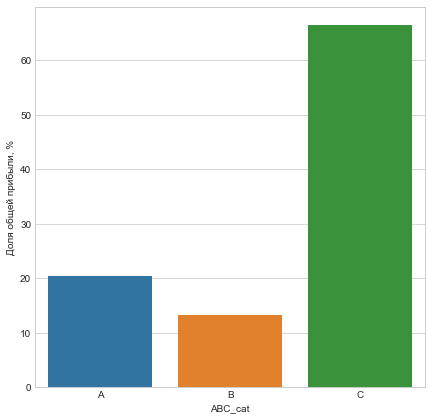

In [338]:
plt.figure(figsize=(7, 7))
sns.barplot(data=df_results, x='ABC_cat', y='Доля общей прибыли, %')



<AxesSubplot:xlabel='ABC_cat', ylabel='Доля в количестве, %'>

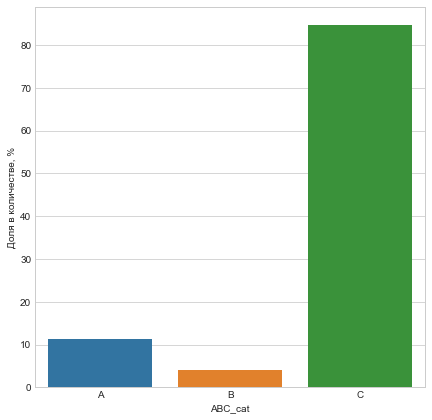

In [339]:
plt.figure(figsize=(7, 7))
sns.barplot(data=df_results, x='ABC_cat', y='Доля в количестве, %')

# Задание 3

- Есть исходные данные (там 3 файла с данными с Яндекс Метрики из реального интернет-магазина)  
- Посмотрите какие выводы вы можете сделать по этим данным? Напишите их в том же Google Docs файле на листе “Анализ интернет-магазина
- Попробуйте визуализировать данные так, чтоб от них была польза для маркетолога и владельца этого интернет-магазина (любым удобным для вас способом).

In [340]:
#read_data:
visits = pd.read_excel('./task_3/data/Визиты.xlsx')
lids = pd.read_excel('./task_3/data/Лиды.xlsx')
rejects = pd.read_excel('./task_3/data/Отказы.xlsx')

In [341]:
visits.head(2)

,Период,yandex_search,2gis_main,yandexmaps_button,google_cpc,yandex_retargeting,2gis_button,yandexmaps_promo,google_search,yandex_rsya,2gis_link,google_remarketing,googlemaps,geoadv_search_yabs,yandex_seo
0,2022-01-01 - 2022-01-02,64,31,9,16,68,12,0,24,1,3,10,20,0,0
1,2022-01-03 - 2022-01-09,685,197,62,100,374,90,0,226,1,4,33,161,0,0


In [342]:
lids.head(2)

,Период,yandex_search,2gis_main,yandexmaps_button,google_cpc,yandex_retargeting,2gis_button,yandexmaps_promo,google_search,yandex_rsya,2gis_link,google_remarketing,googlemaps,geoadv_search_yabs,yandex_seo
0,2022-01-01 - 2022-01-02,2,0,1,0,0,0,0,1,0,0,0,1,0,0
1,2022-01-03 - 2022-01-09,26,7,1,1,6,4,0,10,0,1,1,7,0,0


In [343]:
rejects.head(2)

,Период,yandex_search,2gis_main,yandexmaps_button,google_cpc,yandex_retargeting,2gis_button,yandexmaps_promo,google_search,yandex_rsya,2gis_link,google_remarketing,googlemaps,geoadv_search_yabs,yandex_seo
0,2022-01-01 - 2022-01-02,0.062500,0.000000,0.111111,0.3125,0.250000,0.166667,0.0,0.125000,0.0,0.0,0.500000,0.000000,0,0.0
1,2022-01-03 - 2022-01-09,0.113869,0.076142,0.048387,0.1700,0.173797,0.088889,0.0,0.168142,0.0,0.0,0.424242,0.068323,0,0.0


Посмотрим на суммарные значения:

In [352]:
#
for channel in (visits.columns):
    print(channel)

Период
yandex_search
2gis_main
yandexmaps_button
google_cpc
yandex_retargeting
2gis_button
yandexmaps_promo
google_search
yandex_rsya
2gis_link
google_remarketing
googlemaps
geoadv_search_yabs
yandex_seo


In [351]:
yandex_search_visits_sum = visits['yandex_search'].sum()
yandex_search_lids_sum = lids['yandex_search'].sum()
yandex_search_rejects_mean = rejects['yandex_search'].mean()
yandex_search = pd.DataFrame({
    'visits_sum': [yandex_search_visits_sum],
    'lids_sum': [yandex_search_lids_sum],
    'rejects_mean': [yandex_search_rejects_mean],
    'channel': ['yandex_search']
})
yandex_search

,visits_sum,lids_sum,rejects_mean,channel
0,38369,1241,0.145543,yandex_search
